In [1]:
%matplotlib inline
import sys
BIN = '../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
import fastai

In [2]:
from my_nn_modules import AE_big

In [3]:
#fastai.torch_core.defaults.device = 'cuda'

In [4]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')
n_features = len(train.loc[0])

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


In [5]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

In [6]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [7]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

In [8]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [9]:
db

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x125a87358>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x125a87ba8>;

Test: None

In [10]:
class AE_big(nn.Module):
    def __init__(self, n_features=4):
        super(AE_big, self).__init__()
        self.en1 = nn.Linear(n_features, 50)
        self.bn1 = nn.BatchNorm1d(50)
        self.en2 = nn.Linear(50, 50)
        self.bn2 = nn.BatchNorm1d(50)
        self.en3 = nn.Linear(50, 20)
        self.bn3 = nn.BatchNorm1d(20)
        self.en4 = nn.Linear(20, 3)
        self.bn5 = nn.BatchNorm1d(3)
        self.de1 = nn.Linear(3, 20)
        self.bn6 = nn.BatchNorm1d(20)
        self.de2 = nn.Linear(20, 50)
        self.bn7 = nn.BatchNorm1d(50)
        self.de3 = nn.Linear(50, 50)
        self.bn8 = nn.BatchNorm1d(50)
        self.de4 = nn.Linear(50, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        h1 = self.tanh(self.bn1(self.en1(x)))
        h2 = self.tanh(self.bn2(self.en2(h1)))
        h3 = self.tanh(self.bn3(self.en3(h2)))
        z = self.en4(h3)
        return z

    def decode(self, x):
        h5 = self.tanh(self.bn6(self.de1(self.tanh(self.bn5(x)))))
        h6 = self.tanh(self.bn7(self.de2(h5)))
        h7 = self.tanh(self.bn8(self.de3(h6)))
        return self.de4(h7)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-8-6-4-3-4-6-8-out'

In [11]:
model = AE_big()

In [12]:
#def my_loss_func(input, target):
#    np.power(target - input, 2).mean()
loss_func = nn.MSELoss()
#loss_func = my_loss_func
#loss_func = model.ae_loss
#learn = basic_train.Learner(data=db, model=model, loss_func=loss_func)

In [13]:
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func)

In [14]:
from fastai import train as tr
tr.lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


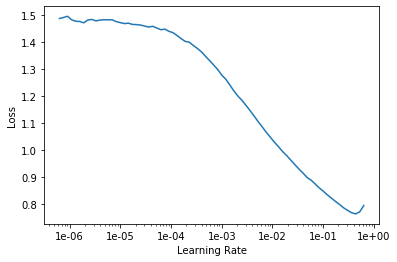

In [15]:
learn.recorder.plot()

In [ ]:
lr = 3e-3
learn.fit_one_cycle(2, max_lr=lr, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.012694,0.006130,02:29


In [ ]:
learn.recorder.plot_losses()

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


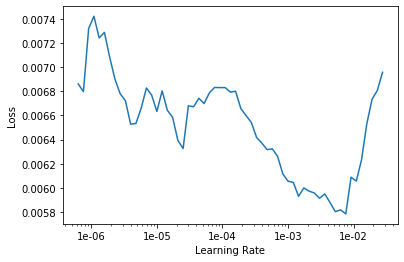

In [19]:
tr.lr_find(learn)
learn.recorder.plot()

In [29]:
lr = 3e-4
learn.fit_one_cycle(4, max_lr=lr, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.007359,0.008244,01:01
1,0.008133,0.016916,01:04
2,0.007393,0.002374,01:01
3,0.006795,0.002823,01:01


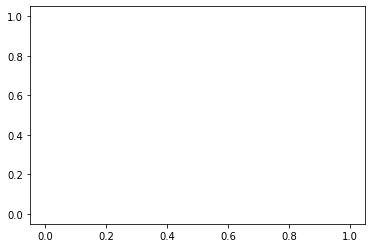

In [31]:
plt.plot(learn.recorder.val_losses, marker='>')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


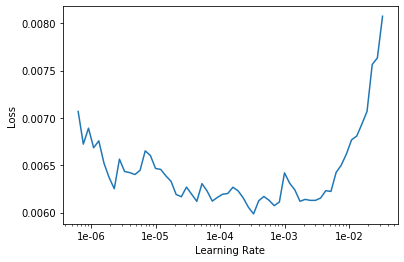

In [32]:
tr.lr_find(learn)
learn.recorder.plot()

In [ ]:
lr = 1e-5
learn.fit_one_cycle(4, max_lr=lr, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.006821,0.002054,01:02
1,0.384831,0.005293,01:03
2,0.007581,0.002664,01:01


In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
tr.lr_find(learn)
learn.recorder.plot()

In [ ]:
inp = learn.data.train_ds.tensors[0][0]
outp = model(learn.data.train_ds.tensors[0][0])
print('Input:', inp)
print('Output:', outp)

In [ ]:
learn.data.train_ds.tensors[0][0]

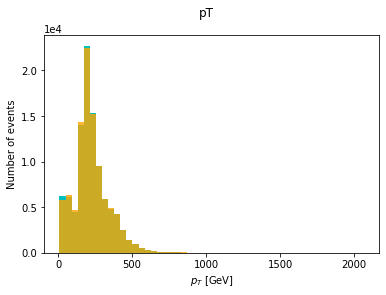

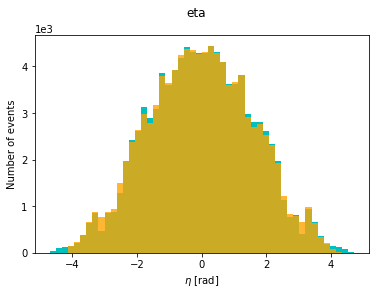

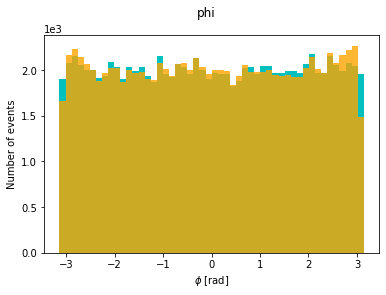

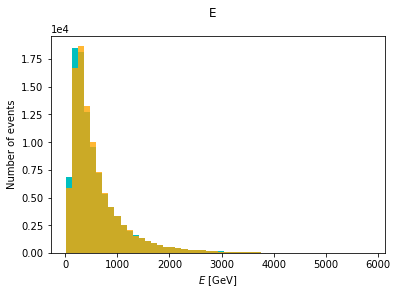

In [33]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()

## Check low pT reconstruction

In [41]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')

train = train[train['pT']<100]
test = test[test['pT']<100]
train.head()

,pT,eta,phi,E
1739612,79.819145,4.535507,-1.185196,3722.832764
213212,74.533775,0.010658,-0.424795,74.770332
133632,73.335709,-0.998801,0.981093,113.546120
1321860,78.281624,1.674880,-2.164416,216.534836
1877459,57.215500,-3.269782,-0.657705,753.719360


In [42]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=512)

db = basic_data.DataBunch(train_dl, valid_dl)

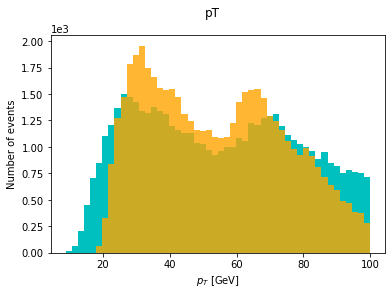

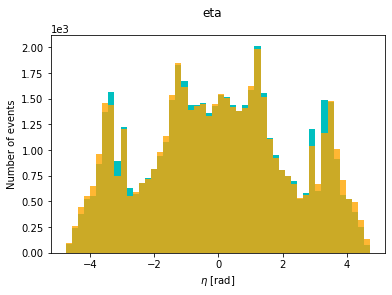

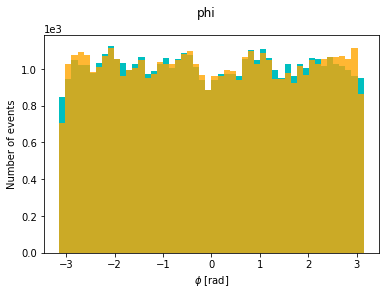

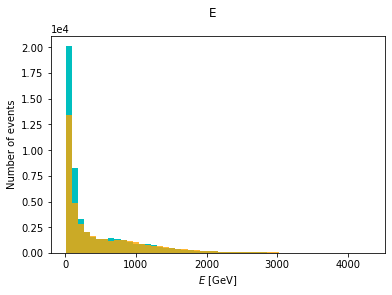

In [43]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()